In [1]:
# Creates Dataset where values are for the probabilistic contingency table

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import cartopy as cp
from matplotlib.patches import FancyArrowPatch
from scipy.ndimage import map_coordinates
import metpy.calc as mpcalc
from geographiclib.geodesic import Geodesic
from utils_datetime import *
from utils_filter import *
from geopy import Nominatim

In [3]:
# load grid pph and outlook
pph = xr.open_dataset('data/pph/labelled_pph.nc')
outlooks = xr.open_dataset('data/outlooks/grid_outlooks.nc')


In [4]:
# dataset in time, a/b/c/d, hazard
hazard_types= ['Wind', 'Hail', 'Tornado', 'All Hazard']
regions = ['West', 'Great Plains', 'Midwest', 'South', 'Northeast', 'CONUS']

contingency_dataset = xr.Dataset(
    data_vars=dict(
        a=(['time', 'hazard', 'region'], np.full((len(pph['time']), len(hazard_types), len(regions)), 0.0)),
        b=(['time', 'hazard', 'region'], np.full((len(pph['time']), len(hazard_types), len(regions)), 0.0)),
        c=(['time', 'hazard', 'region'], np.full((len(pph['time']), len(hazard_types), len(regions)), 0.0)),
        d=(['time', 'hazard', 'region'], np.full((len(pph['time']), len(hazard_types), len(regions)), 0.0))
    ),
    coords=dict(
        time=(['time'], pph['time'].data),
        hazard=(['hazard'], hazard_types),
        region = (['region'], regions)
    ),
    attrs=dict(description="Number of a, b, c, and d in contingency tables for each day and hazard type, as calculated probabilistically from outlook and PPH probabilities")
)

In [5]:
contingency_dataset

<xarray.Dataset>
Dimensions:  (time: 16436, hazard: 4, region: 6)
Coordinates:
  * time     (time) object '197901010000' '197901020000' ... '202312310000'
  * hazard   (hazard) <U10 'Wind' 'Hail' 'Tornado' 'All Hazard'
  * region   (region) <U12 'West' 'Great Plains' ... 'Northeast' 'CONUS'
Data variables:
    a        (time, hazard, region) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    b        (time, hazard, region) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    c        (time, hazard, region) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    d        (time, hazard, region) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  Number of a, b, c, and d in contingency tables for each day...

In [6]:
pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_totalsvr'
}

outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}

oldyear = 0

In [7]:
geolocator = Nominatim(user_agent="severe_thunderstorm_miles_new1")

Generating masks for each region

In [8]:
def get_state(lat, lon, geolocator):
    location = geolocator.reverse(str(lat)+","+str(lon))
    if location == None:
        return None
    address = location.raw['address']
    state = address.get('state', '')
    return state

regions_dict = { # list of states fully within each region (doesn't include AK, HI, CO, NM)
        'West': ['Washington', 'Oregon', 'California', 'Idaho', 'Montana', 'Wyoming', 'Utah', 'Arizona'],
        'Midwest': ['North Dakota', 'South Dakota', 'Minnesota', 'Iowa', 'Wisconsin', 'Illinois', 'Michigan', 'Indiana', 'Ohio', 'Kentucky'],
        'Great Plains': ['Nebraska', 'Kansas', 'Oklahoma', 'Texas', 'Missouri'],
        'Northeast': ['Maine', 'Vermont', 'New Hampshire', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey', 'Delaware', 'Maryland', 'District of Columbia', 'West Virginia'],
        'South': ['Virginia', 'Arkansas', 'Louisiana', 'Tennessee', 'Mississippi', 'Alabama', 'Georgia', 'North Carolina', 'South Carolina', 'Florida']
    }

geolocator = Nominatim(user_agent="severe_thunderstorm_miles53")
west_threshold_co_nm = -105

def mask_function(lat, lon):

    if lat > 49 or lat < 24 or lon < -125 or lon > -65:
        return None
    
    elif lat < 31 and lon < -108:
        return None
    
    elif lat < 32 and lon > -80:
        return None
    
    elif lat > 35 and lat < 49 and lon > -121 and lon < -105:
        return 'West'
    
    elif lat > 33 and lat < 41 and lon > -105 and lon < -95:
        return 'Great Plains'
    
    elif lat > 31 and lat < 35 and lon > -83 and lon < -93:
        return 'South'
    


    state = get_state(lat, lon, geolocator)
    print(state)
    if state == None:
        return None
    if state == 'Colorado' or state == 'New Mexico':
        if lon < west_threshold_co_nm:
            return 'West'
        else:
            return 'Great Plains'
    for region in regions_dict:
        if state in regions_dict[region]:
            return region

In [9]:
# Initialize an empty array for the mask
mask = np.empty_like(pph['lat'].values, dtype=object)

# Loop over each grid point
for i in range(pph['lat'].shape[0]):  # Loop over the latitude dimension
    for j in range(pph['lat'].shape[1]):  # Loop over the longitude dimension
        lat = pph['lat'].values[i, j]
        lon = pph['lon'].values[i, j]
        print(lat, lon)
        mask[i, j] = mask_function(lat, lon)


12.1899995803833 -133.45899963378906
12.387932777404785 -132.7574005126953
12.582452774047852 -132.05372619628906
12.773533821105957 -131.34799194335938
12.961150169372559 -130.64024353027344
13.145278930664062 -129.93048095703125
13.325896263122559 -129.21878051757812
13.50297737121582 -128.505126953125
13.67650032043457 -127.78958129882812
13.846443176269531 -127.0721664428711
14.012784004211426 -126.35291290283203
14.175500869750977 -125.6318588256836
14.334573745727539 -124.90904235839844
14.489980697631836 -124.18449401855469
14.641703605651855 -123.45824432373047
14.78972339630127 -122.73033142089844
14.934019088745117 -122.00079345703125
15.07457447052002 -121.26966857910156
15.211371421813965 -120.53699493408203
15.344391822814941 -119.80281066894531
15.473620414733887 -119.06714630126953
15.599039077758789 -118.3300552368164
15.720633506774902 -117.59156036376953
15.838387489318848 -116.85171508789062
15.952286720275879 -116.11054992675781
16.06231689453125 -115.36811065673828

KeyboardInterrupt: 

In [111]:
np.isin(mask, ['West', 'South']).mean()

0.11282051282051282

In [140]:
np.save('conus_mask.npy', mask) 

In [149]:
np.unique(np.where(mask == None, 'F', mask))

array(['F', 'Great Plains', 'Midwest', 'Northeast', 'South', 'West'],
      dtype=object)

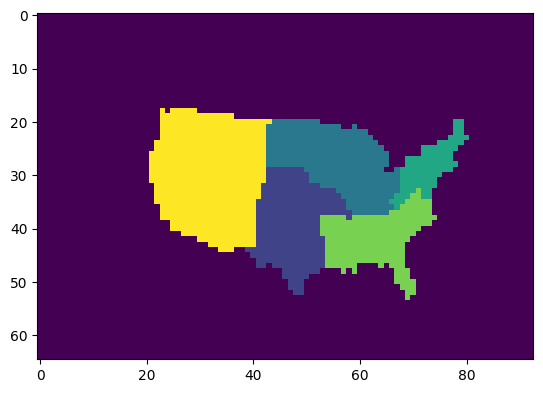

In [11]:
mask = np.load('conus_mask.npy', allow_pickle=True)

unique_values = sorted(set(value for row in mask for value in row if value is not None))

# Create a mapping for the strings and None
value_to_int = {val: i for i, val in enumerate(unique_values)}
value_to_int[None] = -1  # Assign -1 for None

# Convert the 2D array to integers and ensure numerical dtype
int_data = np.array([[value_to_int[val] for val in row] for row in mask[::-1]], dtype=int)
plt.imshow(int_data)

In [ ]:
for time in pph['time']:
    year = str(time.values)[:4]
    if year != oldyear:
        oldyear = year
        print(year)
    for hazard in hazard_types:
        for region in regions:
            o = outlooks.sel(time = time, outlook = outlook_key_dict[hazard])['prob'].values
            p = pph.sel(time = time)[pph_key_dict[hazard]].values/100

            if region == 'CONUS':
                o = o * np.isin(mask, [regions])
                p = p * np.isin(mask, [regions])
                o_ = (1-o) * np.isin(mask, [regions])
                p_ = (1-p) * np.isin(mask, [regions])
            else:
                o = o * (mask == region)
                p = p * (mask == region)
                o_ = (1-o) * (mask == region)
                p_ = (1-p) * (mask == region)

            a = np.multiply(o, p).sum()
            b = np.multiply(o, p_).sum()
            c = np.multiply(o_, p).sum()
            d = np.multiply(o_, p_).sum()

            contingency_dataset['a'].loc[dict(time = time, hazard = hazard, region = region)] = a
            contingency_dataset['b'].loc[dict(time = time, hazard = hazard, region = region)] = b
            contingency_dataset['c'].loc[dict(time = time, hazard = hazard, region = region)] = c
            contingency_dataset['d'].loc[dict(time = time, hazard = hazard, region = region)] = d

        
        



1979
1980


In [ ]:
# check that our dataset checks out
old_dataset = xr.open_dataset('data/contingency/contingency.nc')
contingency_dataset.sel(region = 'CONUS')['c'].sum(), old_dataset['c'].sum(), contingency_dataset.sel(region = np.isin(contingency_dataset['region'], regions))['c'].sum()/2



(<xarray.DataArray 'c' ()>
 array(495868.36973701)
 Coordinates:
     region   <U12 'CONUS',
 <xarray.DataArray 'c' ()>
 array(528700.65193727),
 <xarray.DataArray 'c' ()>
 array(495868.36973701))

In [135]:
contingency_dataset.to_netcdf('data/contingency/contingency_regions.nc')